# Lecture7; Regularization

### Library

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, initializers
import numpy as np
from matplotlib import pyplot as plt
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### Data processing

In [2]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_trainval, x_test = tf.cast(x_trainval, tf.float32), tf.cast(x_test, tf.float32)
y_trainval, y_test = tf.cast(y_trainval, tf.float32), tf.cast(y_test, tf.float32)

num_classes = 10
num_features = 784

x_trainval, x_test = tf.reshape(x_trainval,[-1, num_features]), tf.reshape(x_test, [-1, num_features])
x_trainval, x_test = x_trainval / 255., x_test / 255.

In [3]:
# s = np.random.permutation(10)
# print(s)

[2 8 4 9 1 6 7 3 0 5]


In [4]:
# x = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# y = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# x_2 = tf.gather(x,s)
# y_2 = tf.gather(y,s)
# print(x_2)
# print(y_2)
# x_t = x_2[:8]
# x_v = x_2[8:]
# y_t = y_2[:8]
# y_v = y_2[8:]
# print(x_t)
# print(y_t)

tf.Tensor([2 8 4 9 1 6 7 3 0 5], shape=(10,), dtype=int32)
tf.Tensor([2 8 4 9 1 6 7 3 0 5], shape=(10,), dtype=int32)
tf.Tensor([2 8 4 9 1 6 7 3], shape=(8,), dtype=int32)
tf.Tensor([2 8 4 9 1 6 7 3], shape=(8,), dtype=int32)


In [5]:
indices = np.random.permutation(x_trainval.shape[0])
x_trainval = tf.gather(x_trainval, indices)
y_trainval = tf.gather(y_trainval, indices)
x_train = x_trainval[:50000]
x_val = x_trainval[50000:]
y_train = y_trainval[:50000]
y_val = y_trainval[50000:]

In [6]:
print(x_train.shape) #(50000, 784)
print(x_val.shape) #(10000, 784)
print(x_test.shape) #(10000, 784)

print(y_train.shape) #(50000,)
print(y_val.shape) #(10000,)
print(y_test.shape) #(10000,)

(50000, 784)
(10000, 784)
(10000, 784)
(50000,)
(10000,)
(10000,)


In [7]:
batch_size = 200
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(50000).batch(batch_size).prefetch(1)

### Define functions for Training/Testing

In [8]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x) # softmax 안쓴애들한테 쓰는 함수
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(y, x) 방법 찾아야됨
    return tf.reduce_mean(loss)

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    
def Train_model(model, lr, epo, print_loss=True, plot_graph=True):
    step_l = []
    loss_l = []
    
    optimizer = tf.optimizers.SGD(0.01, momentum=0.9)
    
    for epoch in range(1,epo+1):
        for step, (batch_x, batch_y) in enumerate(train_data, 1):
            with tf.GradientTape() as g:
                pred = model(batch_x, is_training=True)
                loss = cross_entropy_loss(pred, batch_y)

            trainable_variables = model.trainable_variables
            gradients = g.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            
            if plot_graph:
                if step % 50 == 0:
                    step_l.append((epoch-1)*300 + step)
                    loss_l.append(loss.numpy())
        if print_loss:
            acc = accuracy(model(x_test), y_test)
            print("epoch: ", epoch, ", loss: ", loss.numpy(), "acc: ", acc)
    
    if plot_graph:
        plt.plot(step_l, loss_l)
    return model

In [9]:
class NeuralNet(Model):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal())
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal())
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal())

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.out(x)
        
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

## Early stopping

In [12]:
import sys
import copy

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.shuffle(10000).batch(batch_size).prefetch(1)

def early_stopping(model, lr):
    el = []
    vll = []
    
    p = 5 #patience
    i = 0
    j = 0
    v = sys.float_info.max  
    model_s = copy.deepcopy(model) 
    i_s = i #i_star
    
    while j < p : 
        Train_model(model, lr, 1, print_loss=False, plot_graph=False) 

        acc = accuracy(model(x_val), y_val) * 100.
        tmp_v = 100. - acc # v'
        i += 1
        print("epoch reached ", i, ": current_val_error = ", tmp_v, "(%) / smallest_error = ", v, "(%)")
        el.append(i)
        vll.append(tmp_v) 
                               
        if tmp_v < v : 
            j = 0                          
            model_s = copy.deepcopy(model)
            i_s = i                        
            v = tmp_v                     
        else : 
            j += 1                         
    
    plt.plot(el, vll)
    print("best_epoch =", i_s)
    return model_s, i_s

epoch reached  1 : current_val_error =  5.720001459121704 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  4.079997539520264 (%) / smallest_error =  5.720001459121704 (%)
epoch reached  3 : current_val_error =  3.3699989318847656 (%) / smallest_error =  4.079997539520264 (%)
epoch reached  4 : current_val_error =  3.1300008296966553 (%) / smallest_error =  3.3699989318847656 (%)
epoch reached  5 : current_val_error =  3.020000457763672 (%) / smallest_error =  3.1300008296966553 (%)
epoch reached  6 : current_val_error =  2.740001678466797 (%) / smallest_error =  3.020000457763672 (%)
epoch reached  7 : current_val_error =  2.719998359680176 (%) / smallest_error =  2.740001678466797 (%)
epoch reached  8 : current_val_error =  2.5600016117095947 (%) / smallest_error =  2.719998359680176 (%)
epoch reached  9 : current_val_error =  2.7100026607513428 (%) / smallest_error =  2.5600016117095947 (%)
epoch reached  10 : current_val_error =  2.42000222

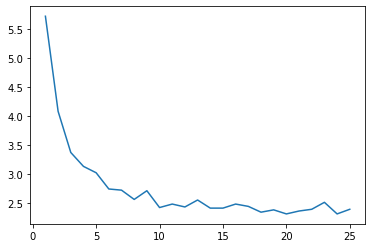

In [13]:
neural_net = NeuralNet()
neural_net, nn_best_epoch = early_stopping(neural_net, 0.01)

In [14]:
n_acc = accuracy(neural_net(x_test), y_test)
print("test accuracy =", n_acc)

test accuracy = 0.9764


## Regularization
### weight decay

regularizer 종류 : https://www.tensorflow.org/api_docs/python/tf/keras/regularizers

In [15]:
class WD_NeuralNet(Model):
    def __init__(self):
        super(WD_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer=regularizers.l2(0.01))
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer=regularizers.l2(0.01))
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer=regularizers.l2(0.01))

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.out(x)
        
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

epoch reached  1 : current_val_error =  5.4000020027160645 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  4.240000247955322 (%) / smallest_error =  5.4000020027160645 (%)
epoch reached  3 : current_val_error =  3.530001640319824 (%) / smallest_error =  4.240000247955322 (%)
epoch reached  4 : current_val_error =  3.0300021171569824 (%) / smallest_error =  3.530001640319824 (%)
epoch reached  5 : current_val_error =  3.2100021839141846 (%) / smallest_error =  3.0300021171569824 (%)
epoch reached  6 : current_val_error =  2.6099979877471924 (%) / smallest_error =  3.0300021171569824 (%)
epoch reached  7 : current_val_error =  2.5600016117095947 (%) / smallest_error =  2.6099979877471924 (%)
epoch reached  8 : current_val_error =  2.5300025939941406 (%) / smallest_error =  2.5600016117095947 (%)
epoch reached  9 : current_val_error =  2.640002965927124 (%) / smallest_error =  2.5300025939941406 (%)
epoch reached  10 : current_val_error =  2.640

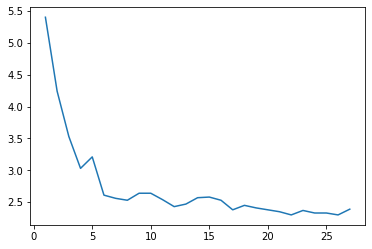

In [16]:
wd_nn = WD_NeuralNet()
wd_nn, wd_best_epoch = early_stopping(wd_nn, 0.01)

In [17]:
wd_acc = accuracy(wd_nn(x_test), y_test)
print("test accuracy =", wd_acc)

test accuracy = 0.9784


### drop out 

In [18]:
# dropout 코딩
class DO_NeuralNet(Model):
    def __init__(self):
        super(DO_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal())
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.do1 = layers.Dropout(rate=0.5)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal())
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.do2 = layers.Dropout(rate=0.5)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal())

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.do1(x, training=is_training)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.do2(x, training=is_training)
        x = self.out(x)
        
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

epoch reached  1 : current_val_error =  8.399999141693115 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  6.970000267028809 (%) / smallest_error =  8.399999141693115 (%)
epoch reached  3 : current_val_error =  5.909997224807739 (%) / smallest_error =  6.970000267028809 (%)
epoch reached  4 : current_val_error =  5.4099977016448975 (%) / smallest_error =  5.909997224807739 (%)
epoch reached  5 : current_val_error =  4.869997501373291 (%) / smallest_error =  5.4099977016448975 (%)
epoch reached  6 : current_val_error =  4.71000075340271 (%) / smallest_error =  4.869997501373291 (%)
epoch reached  7 : current_val_error =  4.269999265670776 (%) / smallest_error =  4.71000075340271 (%)
epoch reached  8 : current_val_error =  4.070001840591431 (%) / smallest_error =  4.269999265670776 (%)
epoch reached  9 : current_val_error =  3.9499998092651367 (%) / smallest_error =  4.070001840591431 (%)
epoch reached  10 : current_val_error =  3.70000004768371

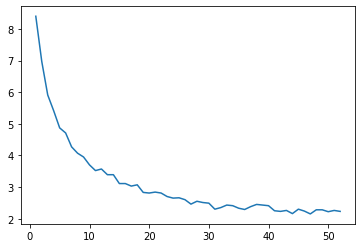

In [19]:
do_nn = DO_NeuralNet()
do_nn, do_best_epoch = early_stopping(do_nn, 0.01)

In [20]:
do_acc = accuracy(do_nn(x_test), y_test)
print("test accuracy =", do_acc)

test accuracy = 0.9752


### model Ensembles

In [24]:
pred = (neural_net(x_test, is_training=False) + wd_nn(x_test, is_training=False) + do_nn(x_test, is_training=False))/3
ensem_acc = accuracy(pred, y_test)

print(ensem_acc)

0.9809


### Compare accuracy

In [27]:
print(n_acc)
print(wd_acc)
print(do_acc)
print(ensem_acc)

0.9764
0.9784
0.9752
0.9809
